In [1]:
#Library imports
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage import io, color, filters, exposure
from sklearn.preprocessing import StandardScaler
from PIL import Image

In [3]:
#Converting all the images from the four classes to edge histograms

input_folder = "cropped_images"
output_folder = "edge_histograms"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg'))] 


def compute_edge_histogram(image_path):
    I = io.imread(image_path)

    if I.ndim == 3: 
        I = color.rgb2gray(I)

    sobel_h = filters.sobel_h(I)
    sobel_v = filters.sobel_v(I)

    angle = np.arctan2(sobel_v, sobel_h)
    angle = np.mod(angle, np.pi) 
    
    hist, bins = exposure.histogram(angle, nbins=36)  

    return hist

for image_file in image_files:
    image_path = os.path.join(input_folder, image_file)
    
    histogram = compute_edge_histogram(image_path)

    hist_file_path = os.path.join(output_folder, f"{os.path.splitext(image_file)[0]}_histogram.npy")
    np.save(hist_file_path, histogram)

print("All edge histograms have been computed and saved.")

All edge histograms have been computed and saved.


In [4]:
#performing a training/test split of 80/20.

histogram_folder = "edge_histograms"

histograms = []
types = []

for file in os.listdir(histogram_folder):
    if file.endswith('.npy'):
        histogram = np.load(os.path.join(histogram_folder, file))
        histograms.append(histogram)
        if 'n02094433' in file:
            types.append(0)
        elif 'n02099429' in file:
            types.append(1) 
        elif 'n02107142' in file:
            types.append(2)
        elif 'n02111500' in file:
            types.append(3) 

histograms = np.array(histograms)
types = np.array(types)

X_train, X_test, y_train, y_test = train_test_split(histograms, types, test_size=0.2, stratify=types, random_state=42)

train_histograms = (X_train, y_train)
test_histograms = (X_test, y_test)

print("Training set class distribution:", np.bincount(y_train))
print("Testing set class distribution:", np.bincount(y_test))


Training set class distribution: [135 130 125 186]
Testing set class distribution: [34 33 31 46]


In [5]:
#Performing standardization on the training dataset 
# and standardization on the test dataset using the means and variances obtained from the training dataset.
scaler = StandardScaler()

X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

train_histograms_standardized = (X_train_standardized, y_train)
test_histograms_standardized = (X_test_standardized, y_test)

print("Standardized Training Set Shape:", X_train_standardized.shape)
print("Standardized Testing Set Shape:", X_test_standardized.shape)

Standardized Training Set Shape: (576, 36)
Standardized Testing Set Shape: (144, 36)



Stratified 5-fold cross-validation using Naive Bayes...
Mean Validation Accuracy for Naive Bayes: 0.3559
Test Accuracy for Naive Bayes: 0.3125
Test F1-Score for Naive Bayes: 0.2902


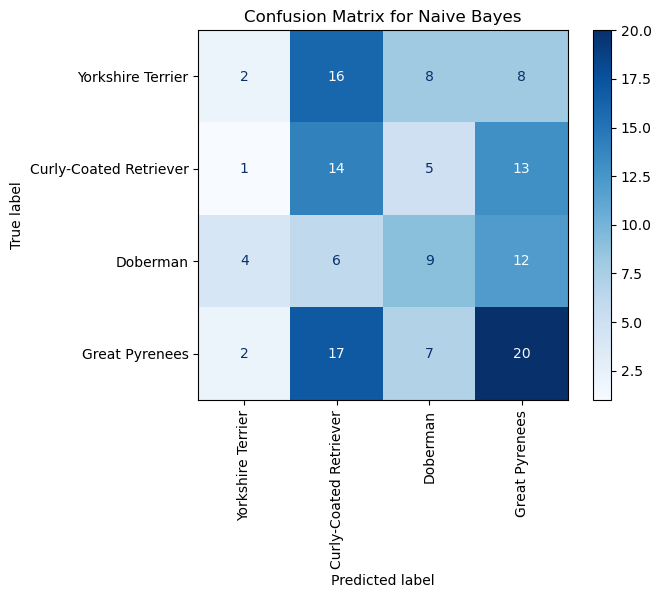


Stratified 5-fold cross-validation using Decision Tree...
Mean Validation Accuracy for Decision Tree: 0.2951
Test Accuracy for Decision Tree: 0.2778
Test F1-Score for Decision Tree: 0.2754


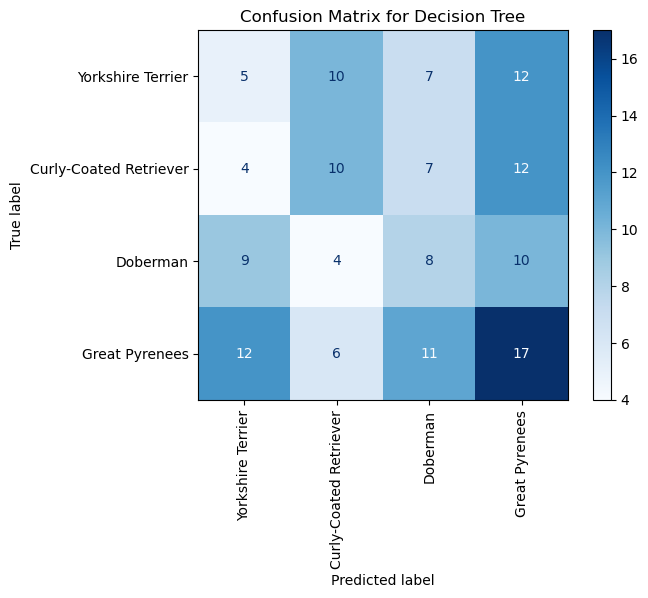


Stratified 5-fold cross-validation using Random Forest...
Mean Validation Accuracy for Random Forest: 0.3540
Test Accuracy for Random Forest: 0.3472
Test F1-Score for Random Forest: 0.3363


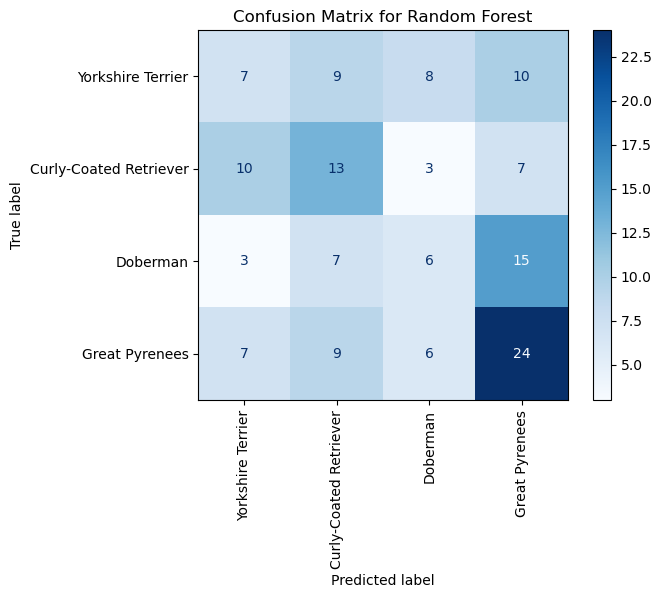


Results:
      Classifier  Mean Validation Accuracy  Test Accuracy  Test F1-Score
0    Naive Bayes                  0.355922       0.312500       0.290228
1  Decision Tree                  0.295142       0.277778       0.275433
2  Random Forest                  0.354048       0.347222       0.336276

Best Method Based on Mean Validation Accuracy: Naive Bayes
Best Method Based on Test Accuracy: Random Forest
Best Method Based on Test F1-Score: Random Forest


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt

X_train, y_train = train_histograms_standardized
X_test, y_test = test_histograms_standardized

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

classifiers = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

results = {'Classifier': [], 'Mean Validation Accuracy': [], 'Test Accuracy': [], 'Test F1-Score': []}

for clf_name, clf in classifiers.items():
    print(f"\nStratified 5-fold cross-validation using {clf_name}...")

    val_accuracies = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        clf.fit(X_fold_train, y_fold_train)

        y_val_pred = clf.predict(X_fold_val)
        val_accuracy = accuracy_score(y_fold_val, y_val_pred)
        val_accuracies.append(val_accuracy)
    
    mean_val_accuracy = np.mean(val_accuracies)

    clf.fit(X_train, y_train)
    
    y_test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1_score = f1_score(y_test, y_test_pred, average='weighted')

    results['Classifier'].append(clf_name)
    results['Mean Validation Accuracy'].append(mean_val_accuracy)
    results['Test Accuracy'].append(test_accuracy)
    results['Test F1-Score'].append(test_f1_score)

    print(f"Mean Validation Accuracy for {clf_name}: {mean_val_accuracy:.4f}")
    print(f"Test Accuracy for {clf_name}: {test_accuracy:.4f}")
    print(f"Test F1-Score for {clf_name}: {test_f1_score:.4f}")

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Yorkshire Terrier', 'Curly-Coated Retriever', 'Doberman', 'Great Pyrenees'])
    
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.title(f'Confusion Matrix for {clf_name}')
    plt.show()

results_df = pd.DataFrame(results)
print("\nResults:")
print(results_df)

best_validation_method = results_df.loc[results_df['Mean Validation Accuracy'].idxmax(), 'Classifier']
best_test_accuracy_method = results_df.loc[results_df['Test Accuracy'].idxmax(), 'Classifier']
best_f1_score_method = results_df.loc[results_df['Test F1-Score'].idxmax(), 'Classifier']

print(f"\nBest Method Based on Mean Validation Accuracy: {best_validation_method}")
print(f"Best Method Based on Test Accuracy: {best_test_accuracy_method}")
print(f"Best Method Based on Test F1-Score: {best_f1_score_method}")


6(a) By visually comparing (e.g., looking at the color on the diagonal values, etc.) the three confusion
matrices (on the test set), which do you think is the best method? Why?

Based on three confusion matrices by visually comparing, Random forest is the best method because it has more correct classifications in the diagonal elements when comparing to other two i.e.., decision tree and naive bayes. Random forest has only a little edge over naive bayes.

References: 
        1. https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/
        2. https://www.geeksforgeeks.org/how-to-plot-confusion-matrix-with-labels-in-sklearn/
        

Filtered Training Data Shape: (316, 36)
Filtered Test Data Shape: (79, 36)


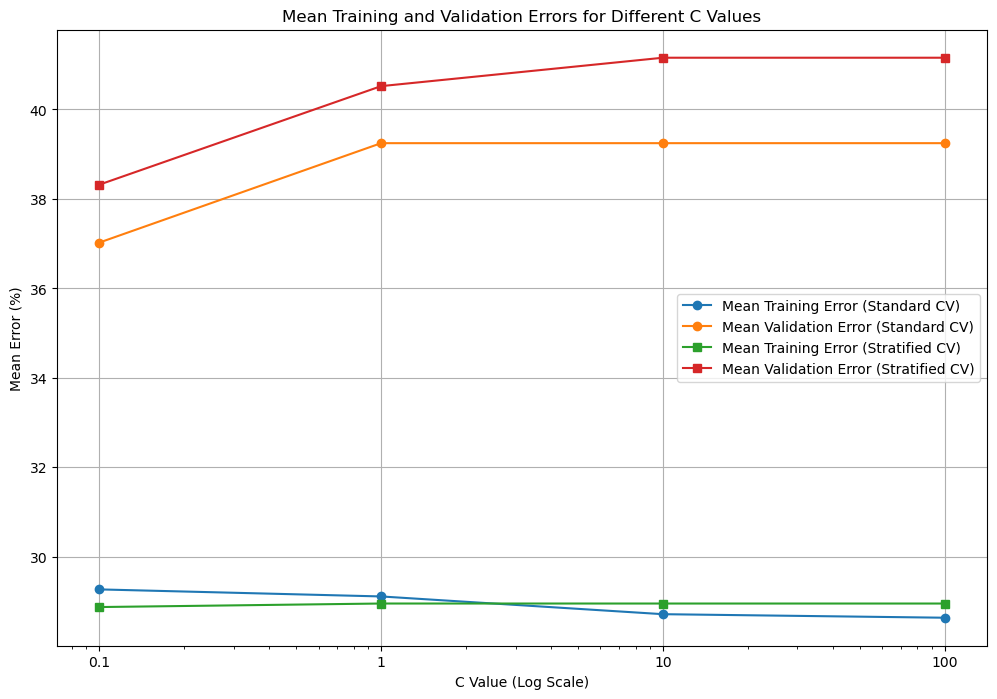

In [7]:
#7
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

X_train, y_train = train_histograms_standardized
X_test, y_test = test_histograms_standardized

class_1 = 1 #curly-coated_retriever
class_2 = 3 #Great_pyrenees

train_mask = np.isin(y_train, [class_1, class_2])

X_train_filtered = X_train[train_mask]
y_train_filtered = y_train[train_mask]

test_mask = np.isin(y_test, [class_1, class_2])

X_test_filtered = X_test[test_mask]
y_test_filtered = y_test[test_mask]


print("Filtered Training Data Shape:", X_train_filtered.shape)
print("Filtered Test Data Shape:", X_test_filtered.shape)

C_values = [0.1, 1, 10, 100]
mean_train_errors_standard = []
mean_val_errors_standard = []
mean_train_errors_stratified = []
mean_val_errors_stratified = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for C in C_values:
    train_errors = []
    val_errors = []
    
    for train_idx, val_idx in kf.split(X_train_filtered):
        X_fold_train, X_fold_val = X_train_filtered[train_idx], X_train_filtered[val_idx]
        y_fold_train, y_fold_val = y_train_filtered[train_idx], y_train_filtered[val_idx]

        model = LinearSVC(C=C, random_state=42, dual=False, max_iter=10000) 
        model.fit(X_fold_train, y_fold_train)
        
        train_error = 1 - model.score(X_fold_train, y_fold_train)
        train_errors.append(train_error)

        val_error = 1 - model.score(X_fold_val, y_fold_val)
        val_errors.append(val_error)

    mean_train_errors_standard.append(np.mean(train_errors)*100)
    mean_val_errors_standard.append(np.mean(val_errors)*100)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for C in C_values:
    train_errors = []
    val_errors = []
    
    for train_idx, val_idx in skf.split(X_train_filtered, y_train_filtered):
        X_fold_train, X_fold_val = X_train_filtered[train_idx], X_train_filtered[val_idx]
        y_fold_train, y_fold_val = y_train_filtered[train_idx], y_train_filtered[val_idx]

        model = LinearSVC(C=C, random_state=42, dual=False,max_iter=10000)
        model.fit(X_fold_train, y_fold_train)

        train_error = 1 - model.score(X_fold_train, y_fold_train)
        train_errors.append(train_error)

        val_error = 1 - model.score(X_fold_val, y_fold_val)
        val_errors.append(val_error)

    mean_train_errors_stratified.append(np.mean(train_errors)*100)
    mean_val_errors_stratified.append(np.mean(val_errors)*100)

plt.figure(figsize=(12, 8))
plt.plot(C_values, np.array(mean_train_errors_standard), label='Mean Training Error (Standard CV)', marker='o')
plt.plot(C_values, np.array(mean_val_errors_standard), label='Mean Validation Error (Standard CV)', marker='o')
plt.plot(C_values, np.array(mean_train_errors_stratified), label='Mean Training Error (Stratified CV)', marker='s')
plt.plot(C_values, np.array(mean_val_errors_stratified), label='Mean Validation Error (Stratified CV)', marker='s')
plt.xscale('log')
plt.xticks(C_values, labels=C_values)
plt.xlabel('C Value (Log Scale)')
plt.ylabel('Mean Error (%)')
plt.title('Mean Training and Validation Errors for Different C Values')
plt.legend()
plt.grid()
plt.show()




In [8]:
print("Standard 5-Fold CV Mean Errors:")
for i, C in enumerate(C_values):
    print(f"C = {C}: Training Error = {mean_train_errors_standard[i]:.2f}%, Validation Error = {mean_val_errors_standard[i]:.2f}%")

print("\nStratified 5-Fold CV Mean Errors:")
for i, C in enumerate(C_values):
    print(f"C = {C}: Training Error = {mean_train_errors_stratified[i]:.2f}%, Validation Error = {mean_val_errors_stratified[i]:.2f}%")

print("\nLowest mean training error (Standard CV) is at C =", C_values[np.argmin(mean_train_errors_standard)])
print("Lowest mean validation error (Standard CV) is at C =", C_values[np.argmin(mean_val_errors_standard)])
print("Lowest mean training error (Stratified CV) is at C =", C_values[np.argmin(mean_train_errors_stratified)])
print("Lowest mean validation error (Stratified CV) is at C =", C_values[np.argmin(mean_val_errors_stratified)])


Standard 5-Fold CV Mean Errors:
C = 0.1: Training Error = 29.27%, Validation Error = 37.02%
C = 1: Training Error = 29.11%, Validation Error = 39.25%
C = 10: Training Error = 28.72%, Validation Error = 39.25%
C = 100: Training Error = 28.64%, Validation Error = 39.25%

Stratified 5-Fold CV Mean Errors:
C = 0.1: Training Error = 28.88%, Validation Error = 38.32%
C = 1: Training Error = 28.96%, Validation Error = 40.52%
C = 10: Training Error = 28.96%, Validation Error = 41.16%
C = 100: Training Error = 28.96%, Validation Error = 41.16%

Lowest mean training error (Standard CV) is at C = 100
Lowest mean validation error (Standard CV) is at C = 0.1
Lowest mean training error (Stratified CV) is at C = 0.1
Lowest mean validation error (Stratified CV) is at C = 0.1


7(a) 1 Comment about (1) the model complexity for SVM in relation to 𝐶
     2 (2) when/whether there is overfitting/underfitting.

Higher C values make the model more complex and have chances of increasing the risk of overfitting, whereas lower C values reduce model complexity by allowing more misclassifications in favor of a larger margin, which reduces the risk of overfitting and enhances generalization, but the lower the C value, the more likely the chances of underfitting.

In [10]:
low_C_val = np.argmin(mean_val_errors_stratified)
low_C = C_values[low_C_val]
print(f'The Low C value from stratified CV is: {low_C}')

final_model = LinearSVC(C=low_C, random_state=42, dual=False,max_iter=10000)
final_model.fit(X_train_filtered, y_train_filtered)

test_error = 1 - final_model.score(X_test_filtered, y_test_filtered)
print(f'Test error for the model with C={low_C}: {test_error} = {test_error * 100:.2f}%')

The Low C value from stratified CV is: 0.1
Test error for the model with C=0.1: 0.40506329113924056 = 40.51%


References:
        1. https://numpy.org/doc/2.0/reference/generated/numpy.isin.html
        2. https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/
        